# Weather-Based Prediction of Wind Turbine Energy Output: A Next-Generation Approach To Renewable Energy Management

## Module I: Data Collection
The dataset used in this project is garnered from the __Wind Turbine Scada Dataset__, which is a standard dataset created by "2018 Scada Data of a Wind Turbine in Turkey"

The data's in the file are:

- Date/Time (for 10 minutes intervals)
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- Theoretical_Power_Curve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

## Module II: Data Pre-processing

#### Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#### Step 2: Import the dataset

In [2]:
path = "data/T1.csv"

df = pd.read_csv(path)

df.rename(columns={
    "Date/Time": "Time",
    "LV ActivePower (kW)": "ActivePower(kW)",
    "Wind Speed (m/s)": "WindSpeed(m/s)",
    "Wind Direction (°)": "Wind_Direction"
}, inplace=True)

# Adjust the time column format
df['Time'] = pd.to_datetime(df['Time'], format="%d %m %Y %H:%M", errors="coerce")

#### Step 3: Exploratory Data Analysis - Dimensionality Reduction

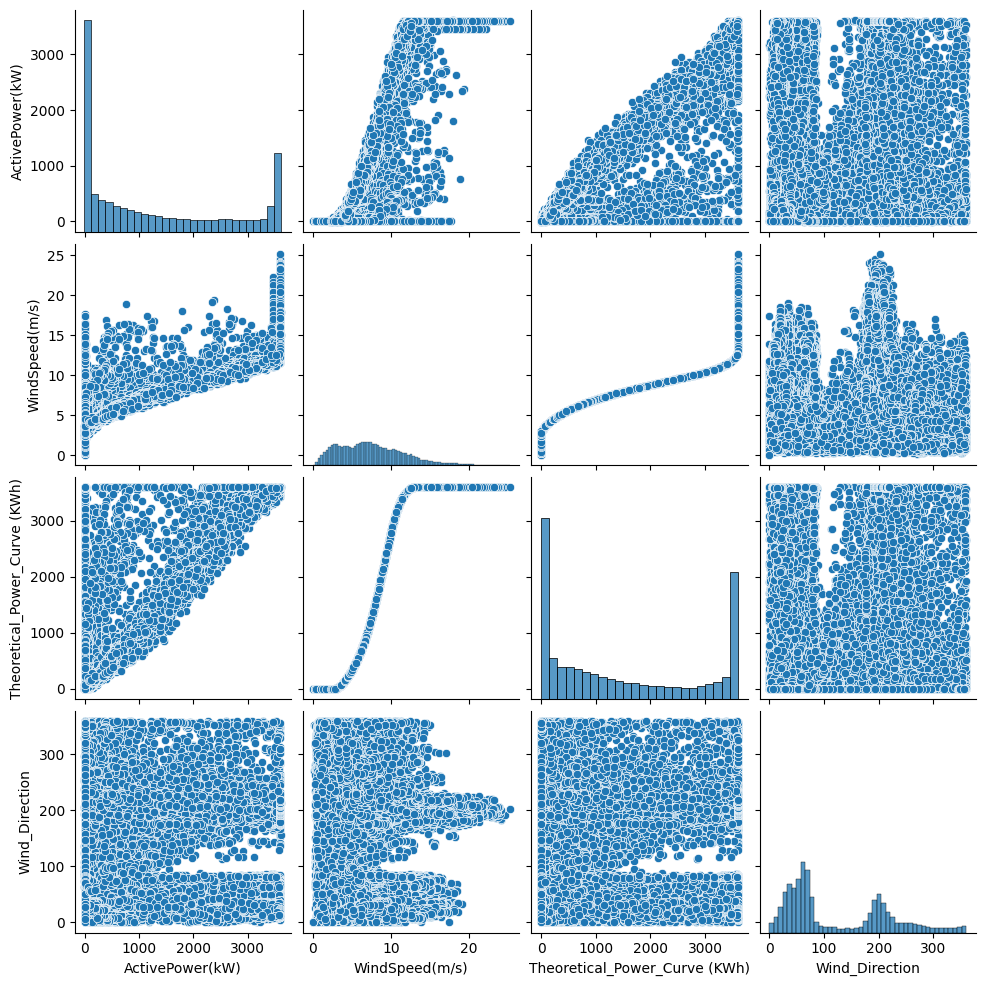

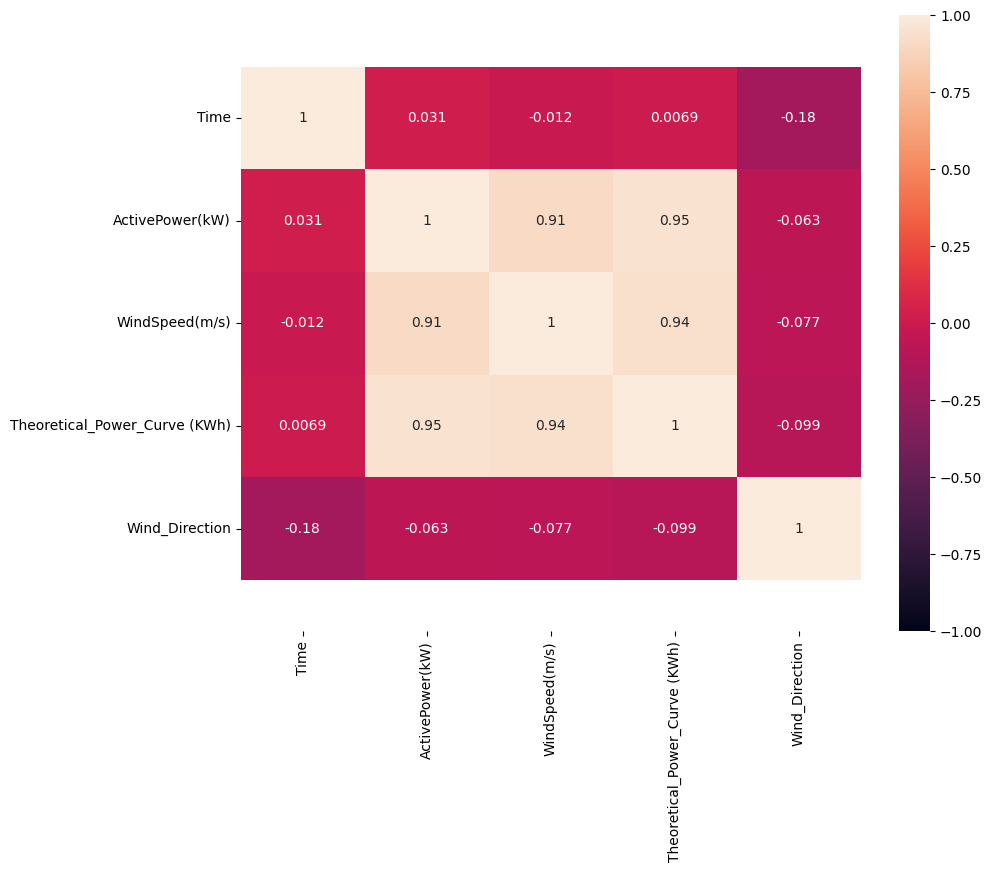

                                   Time  ActivePower(kW)  WindSpeed(m/s)  \
Time                           1.000000         0.030971       -0.012209   
ActivePower(kW)                0.030971         1.000000        0.912774   
WindSpeed(m/s)                -0.012209         0.912774        1.000000   
Theoretical_Power_Curve (KWh)  0.006900         0.949918        0.944209   
Wind_Direction                -0.180336        -0.062702       -0.077188   

                               Theoretical_Power_Curve (KWh)  Wind_Direction  
Time                                                0.006900       -0.180336  
ActivePower(kW)                                     0.949918       -0.062702  
WindSpeed(m/s)                                      0.944209       -0.077188  
Theoretical_Power_Curve (KWh)                       1.000000       -0.099076  
Wind_Direction                                     -0.099076        1.000000  


In [3]:
# Data Visualization

# In seaborn Pair Plot, each variable of the dataset is plotted against all other variables to visualize relation
sns.pairplot(df)

# Plotting correlation between the variables
plt.figure(figsize=(10, 8))
corr = df.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Also print the correlation values
print(corr)

>##### Observations
>- No correlation between Wind Direction and Active Power
>- Strong correlation (0.95) between Active Power and Theoretical Power
>- Significant Correlation between Wind Speed, Active Power and Theoretical Power

In [4]:
# Dropping Wind Direction
df = df.drop(columns=['Wind_Direction'])

#### Step 4: Data Cleaning

In [5]:
# Apply logic filters to delete entries that are physically impossible
CUT_IN_SPEED = 3.5
RATED_POWER = 3600
STOP_SPEED = 25.5

# Power is generated only above the CUT-IN Speed and Turbine is stopped at the Maximum STOP Speed
df = df[(df['WindSpeed(m/s)'] >= CUT_IN_SPEED) & 
        (df['WindSpeed(m/s)'] <= STOP_SPEED)]

# Active Power is always positive and less than rated Power Ceiling
df = df[(df['ActivePower(kW)'] > 0) &
        (df['ActivePower(kW)'] <= RATED_POWER + 100)]

#### Step 5: Splitting Dataset into Training and Testing datasets


In [6]:
# Define Dependent and Independent Variables
y = df['ActivePower(kW)'] # Target, to be predicted
X = df[['Theoretical_Power_Curve (KWh)', 'WindSpeed(m/s)']] # Input to be collected from the user

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)


## Module III: Model Selection and Training

#### Step 1: Determine Variable relation - plot WindSpeed against Active Power

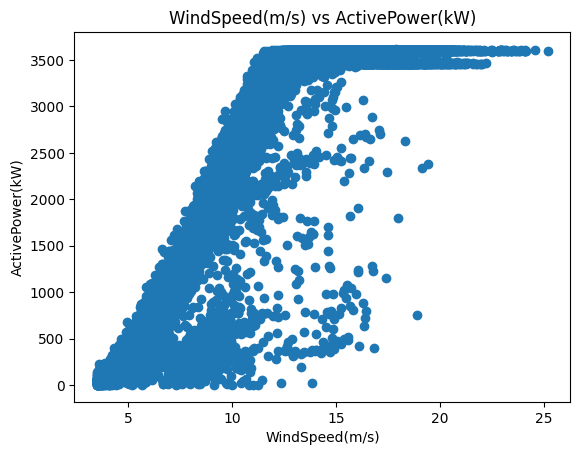

In [7]:
scatter = plt.scatter(
    df['WindSpeed(m/s)'],
    df['ActivePower(kW)']
)
plt.xlabel('WindSpeed(m/s)')
plt.ylabel('ActivePower(kW)')
plt.title("WindSpeed(m/s) vs ActivePower(kW)")
plt.show()

>##### Observations
>- The plot between WindSpeed and Active Power is a non-linear "S" type curve, just like the theoretical power curve.
>- Non-linear regression models are preferred for good accuracy and precision.

#### Step 2: Choosing the Appropriate Model - Random Forest Regressor

In [ ]:
# Random Forest Regressor can handle non-linear relation between the Dependent and Independent Variables
from sklearn.ensemble import RandomForestRegressor

# Initiate the model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=15,
    random_state=42
)

#### Step 3: Model Training

In [9]:
# Train model on the training dataset that was split previously
rf_model.fit(train_X, train_y)

,n_estimators,150
,criterion,'squared_error'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Module IV: Model Evaluation

In [11]:
# Import metric libraries
from sklearn.metrics import r2_score as R2, mean_absolute_error as mae, root_mean_squared_error as rmse

# Predicting for test data
power_preds = rf_model.predict(val_X)

# Calculate Performance Metrics
r2_score = R2(val_y, power_preds)
mean_abs_err = mae(val_y, power_preds)
root_mean_sq_err = rmse(val_y, power_preds)

# Print the metrics
print(f"r2 score: {r2_score} | Mean Absolute Error: {mean_abs_err} | RMSE: {root_mean_sq_err}")


r2 score: 0.9583250196456877 | Mean Absolute Error: 120.31948577146447 | RMSE: 255.29676574654243


>##### Observations
>- Model is performing very well with a r2 score of 0.958, that is, 95.8% Accuracy!

## Module V: Model Dumping

In [12]:
#Saving the model for future Reference
joblib.dump(rf_model, "power_prediction.sav")

['power_prediction.sav']